In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)

# Loading processed data
train_df = pd.read_csv("../data/train_processed.csv", index_col=0)
test_df = pd.read_csv("../data/test_processed.csv", index_col=0)

# Spliting data into x, y
target = "default_next_month"
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (24000, 82)
Test shape: (6000, 82)


In [13]:
def evaluate(model, model_name):

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        probabilities = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, probabilities)
    else:
        probabilities = None
        auc_score = np.nan

    print(f"=== {model_name} ===")
    print(classification_report(y_test, predictions))

    confusion_mat = confusion_matrix(y_test, predictions)
    sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    if probabilities is not None:
        fpr, tpr, _ = roc_curve(y_test, probabilities)
        plt.plot(fpr, tpr, label = f'AUC = {auc_score:.3f}')
        plt.plot([0,1],[0,1],'--', color = 'grey', label = 'Random Guess')
        plt.title(f"ROC Curve: {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

    joblib.dump(model, f"../models/{model_name}.pkl")

    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, predictions),
        "Precision": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "F1": f1_score(y_test, predictions),
        "ROC-AUC": auc_score
    }

Logistic Regression


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4673
           1       0.49      0.56      0.52      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.78      0.77      0.78      6000



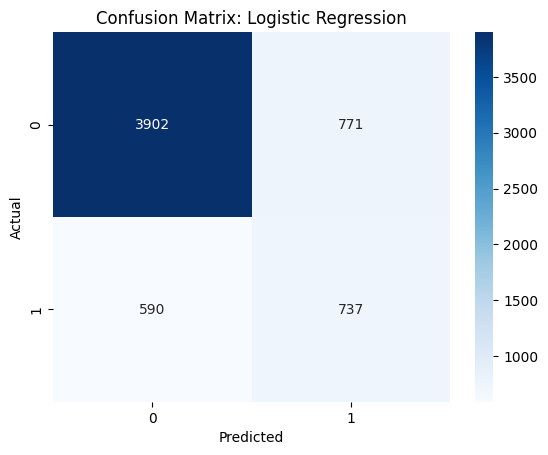

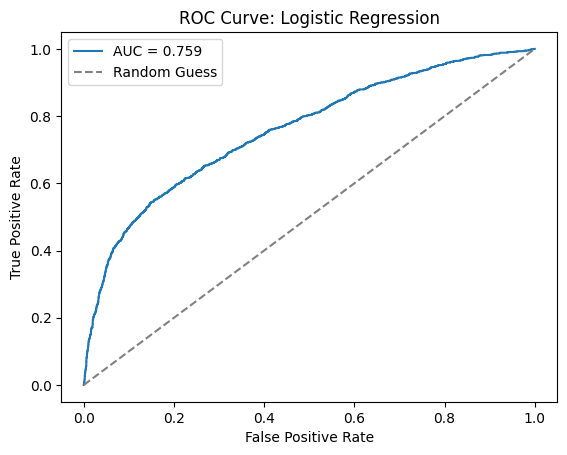

{'Model': 'Logistic Regression',
 'Accuracy': 0.7731666666666667,
 'Precision': 0.4887267904509284,
 'Recall': 0.5553880934438583,
 'F1': 0.5199294532627866,
 'ROC-AUC': 0.7590059846113679}

In [14]:
logistic_model = LogisticRegression(
    class_weight="balanced", 
    max_iter=200,
    random_state=42
)
logistic_results = evaluate(logistic_model, "Logistic Regression")
logistic_results

- Added as a baseline model because it is simple, fast, and easy to understand.
- 

Random Forest

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4673
           1       0.54      0.54      0.54      1327

    accuracy                           0.80      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.80      0.80      0.80      6000



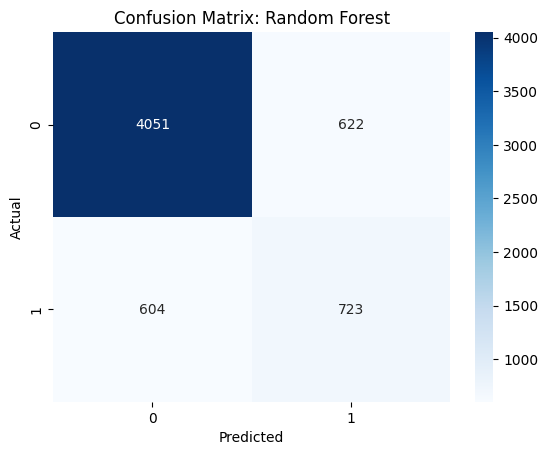

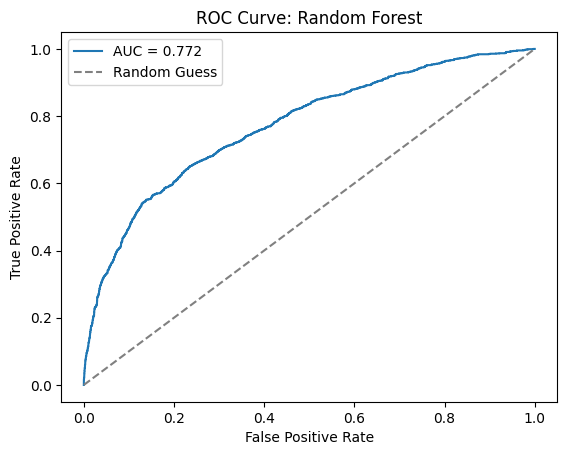

{'Model': 'Random Forest',
 'Accuracy': 0.7956666666666666,
 'Precision': 0.537546468401487,
 'Recall': 0.544837980406933,
 'F1': 0.5411676646706587,
 'ROC-AUC': 0.772044296864203}

In [15]:
random_forest = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight="balanced",
    random_state=42
)
rf_results = evaluate(random_forest, "Random Forest")
rf_results

XGBoost

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.36      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



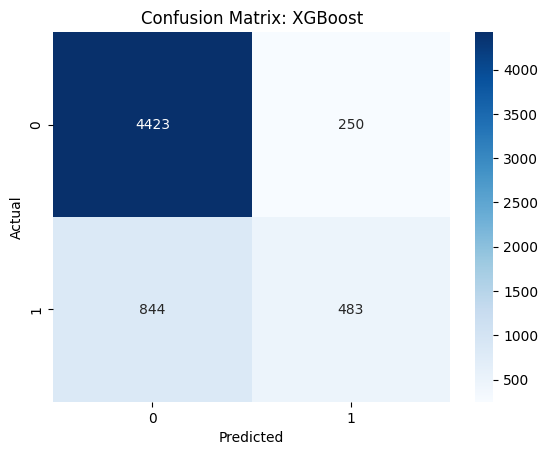

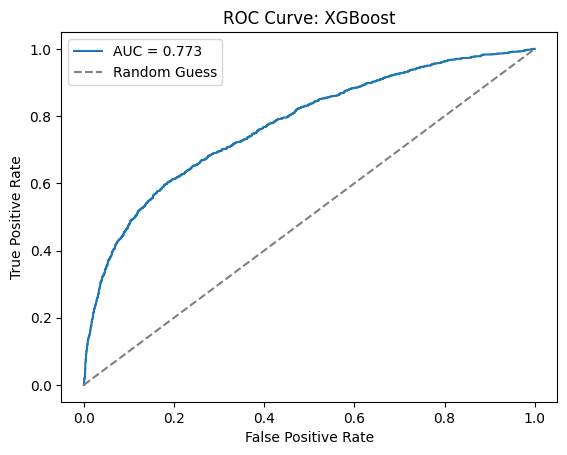

{'Model': 'XGBoost',
 'Accuracy': 0.8176666666666667,
 'Precision': 0.6589358799454298,
 'Recall': 0.36397889977392617,
 'F1': 0.46893203883495144,
 'ROC-AUC': 0.7734443775921933}

In [16]:
xgboost_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)
xgb_results = evaluate(xgboost_model, "XGBoost")
xgb_results

SVM

=== Support Vector Machine ===
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4673
           1       0.69      0.32      0.43      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.66      6000
weighted avg       0.80      0.82      0.79      6000



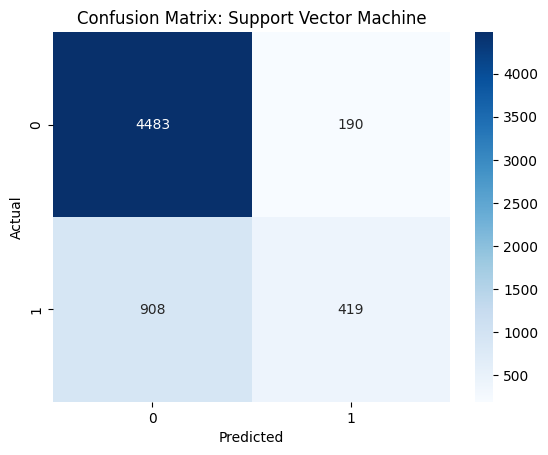

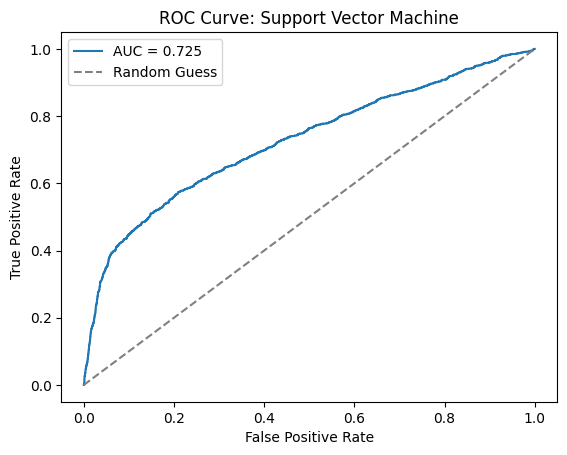

{'Model': 'Support Vector Machine',
 'Accuracy': 0.817,
 'Precision': 0.6880131362889984,
 'Recall': 0.31574981160512433,
 'F1': 0.43285123966942146,
 'ROC-AUC': 0.7249802493795023}

In [17]:
svm_model = SVC(
    kernel="rbf", 
    probability=True,
    random_state=42
)
svm_results = evaluate(svm_model, "Support Vector Machine")
svm_results

In [18]:
all_results = [
    logistic_results,
    rf_results, 
    xgb_results,
    svm_results
]

results_df = pd.DataFrame(all_results)
results_df.sort_values('Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
2,XGBoost,0.817667,0.658936,0.363979,0.468932,0.773444
3,Support Vector Machine,0.817000,0.688013,0.315750,0.432851,0.724980
1,Random Forest,0.795667,0.537546,0.544838,0.541168,0.772044
0,Logistic Regression,0.773167,0.488727,0.555388,0.519929,0.759006


### Summary

 **XGBoost**
- Highest accuracy at 81.8%
- Strong precision of 65.9% 
- Best overall balance between accuracy and stability

**Random Forest**
- Highest recall of 54.5%
- Most effective at identifying actual defaulters

**SVM**
- Accuracy of 81.7% 
- Highest precision of 68.8%
- Reduces variance but misses many defaulters

**Logistic Regression** 
- Accuracy of 77.3%
- Baseline model with moderate performance

### Conclusion
Out of the four models, XGBoost delivered the strongest overall results, achieving the highest accuracy and best ROC-AUC scores.
Random Forest performed well in detecting defaulters but showed lower overall accuracy.
Based on stability and overall performance, XGBoost is selected as the final model.